In [61]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

#Пикабу не пускает без хедеров :с
DEFAULT_HEADERS = {
    "User-Agent": "Mozilla/4.0 (compatible; MSIE 7.0;\ Windows NT 6.0)",
    "Referer": "http://pikabu.ru/",
    "Host": "pikabu.ru",
    "Origin": "pikabu.ru"
}

# Типы сортировки постов по их оценкам и новизне
POSTS_SORT = {"Hot" : "", "Best" : "best/", "New" : "new/"}

class Post():
    """
    Этот класс описывает обьект типа пост, пока что учитываются атрибуты: рейтинг, 
    ссылка на пост, текст, теги и заголовок
    """
    def __init__(self, rating = 0, link = "", text = "", tags = [], title = ""):
        self.rating = rating
        self.link = link
        self.text = text
        self.tags = tags
        self.title = title
    
    def get_tags(self, s):
        all_tags = s.findAll(attrs = ['tags__tag'])
        tags = []
        for i in range(len(all_tags)):
            tag_data = all_tags[i].get("data-tag")
            if not tag_data == None:   
                tags.append(tag_data)
        self.tags = tags

    def get_text(self, s):
        text = s.findAll('p')
        result_txt = ""
        for j in range(len(text)):
            result_txt += text[j].text
        self.text = result_txt

    def get_rating(self, s):
        self.rating = s.get('data-rating') 

    def get_link(self, s):
        self.link = s.find(attrs = ["story__title-link"])['href']
    
    def get_title(self, s):
        self.title = s.find(attrs = ["story__title-link"]).text
    
    def show_data(self):
        print(self.title)
        print(self.rating)
        print(self.link)
        print(self.text)
        print(self.tags)

class Content():
    """
    Контент со страниц сайта пикабу, 
    количество учитываемых страниц задается через конструктор, 
    также задается тип сортировки
    """
    def __init__(self, sort = 'Hot', pages_count = 10):
        self.posts = []
        self.site_url = 'https://pikabu.ru/' 
        self.pages_count = pages_count
        self.sort = POSTS_SORT[sort]
        self.all_tags = dict()
        
    def get_all_posts(self):
        for i in range(self.pages_count):
            r = requests.get(self.site_url + self.sort + "?page=" + str(i), headers=DEFAULT_HEADERS)
            soup = BeautifulSoup(r.text)
            posts_from_page = soup.findAll('article')
            self.get_posts_data(posts_from_page)
            
    def add_new_tags(self, tags):
        for i in tags:
            if i in self.all_tags:
                self.all_tags[i] += 1
            else:
                self.all_tags[i] = 1
            
    def get_posts_data(self, t):        
        for i in range(len(t) - 1):
            post = Post()
            post.get_rating(t[i])
            #Если пост новый или рекламный - оценка None
            #rating = post.rating
            #if (rating == None):
            #    continue
            post.get_link(t[i])
            post.get_text(t[i])
            post.get_tags(t[i])
            post.get_title(t[i])
            self.posts.append(post)
            self.add_new_tags(post.tags)
            
   
            
    def show_all(self):
        for i in self.posts:
            i.show_data()
            

c = Content("Hot", 30)
c.get_all_posts()
#c.show_all()

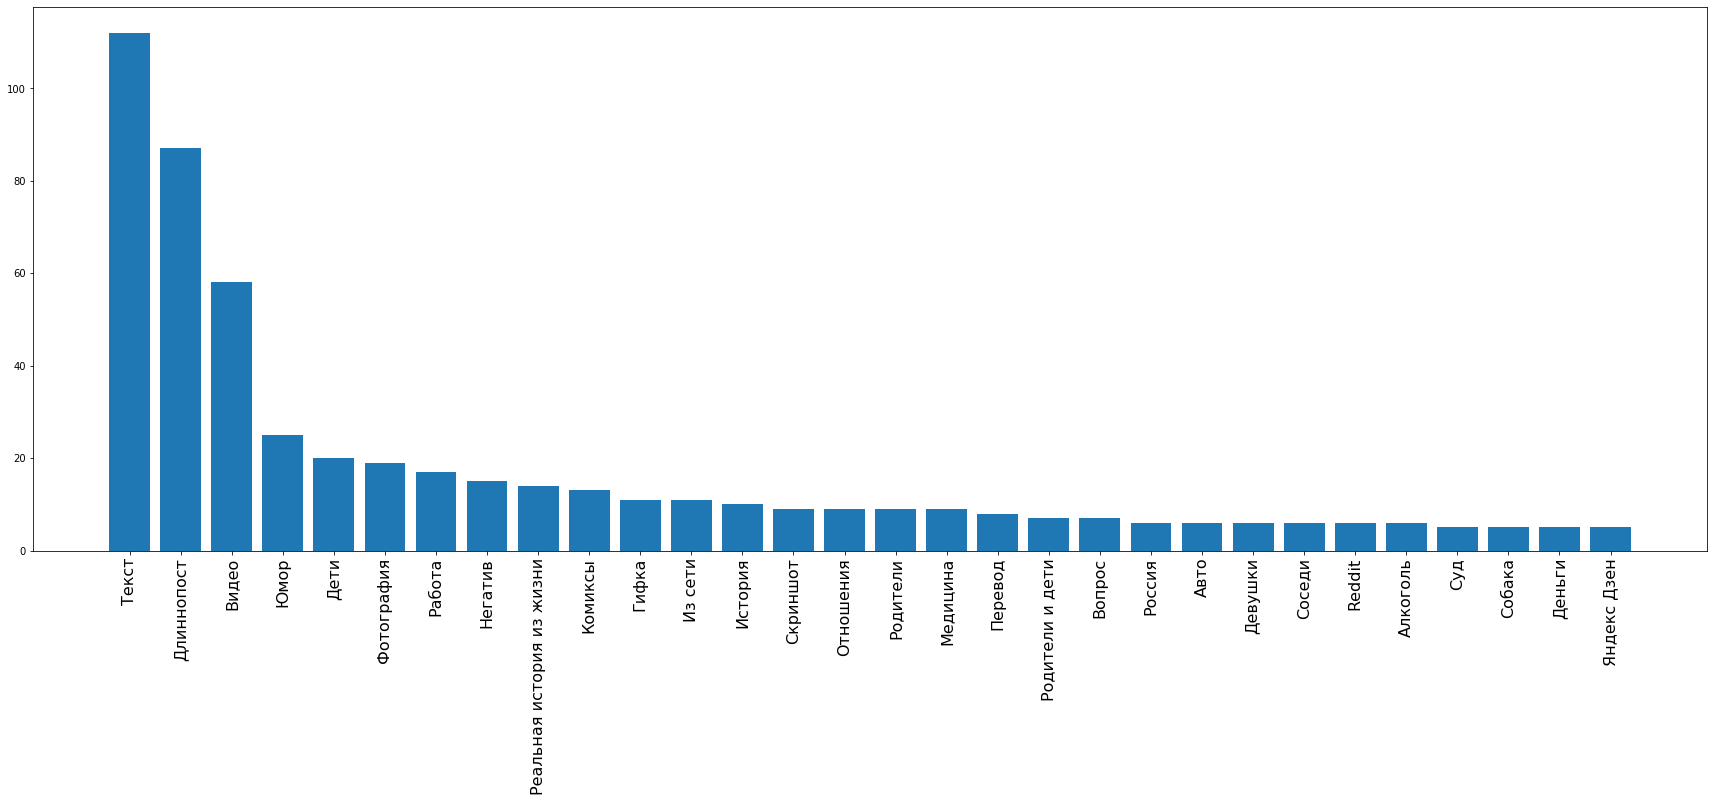

In [60]:
#самые популярные теги за сегодня
import matplotlib.pyplot as plt
list_d = list(c.all_tags.items())
list_d.sort(key=lambda i: i[1])
list_d = list_d[::-1]
list_d = list_d[:30]
x = [i[0] for i in list_d]
y = [i[1] for i in list_d]
t = [i for i in range(len(list_d))]
plt.figure(figsize=(30,10))
plt.bar(t, y)
plt.xticks(t, x, rotation=90, fontsize=16)
plt.show()

In [84]:
p = c.posts
table_of_posts = []
all_text = {}
def create_table():
    for i in range(len(p)):
        all_text[i] = p[i].text
        rating = p[i].rating
        if rating == None:
            rating = 0
        else:
            rating = int(rating)
        s = [p[i].title, rating, i, p[i].tags]
        table_of_posts.append(s)

create_table()
table_of_posts.sort(key=lambda i: -i[1])
#print(table_of_posts)

